# Importing Libararies

In [1]:
import os
import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, load_img, img_to_array
from matplotlib.pyplot import imshow
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

# Looking into structure of file arrangements

In [2]:
DIR = '/kaggle/input/indian-sign-language-islrtc-referred/original_images'

In [4]:
files = os.path.join(DIR, '0')
print(files)
print(sorted(os.listdir(files)))

/kaggle/input/indian-sign-language-islrtc-referred/original_images/0
['1.jpg', '10.jpg', '100.jpg', '1000.jpg', '101.jpg', '102.jpg', '103.jpg', '104.jpg', '105.jpg', '106.jpg', '107.jpg', '108.jpg', '109.jpg', '11.jpg', '110.jpg', '111.jpg', '112.jpg', '113.jpg', '114.jpg', '115.jpg', '116.jpg', '117.jpg', '118.jpg', '119.jpg', '12.jpg', '120.jpg', '121.jpg', '122.jpg', '123.jpg', '124.jpg', '125.jpg', '126.jpg', '127.jpg', '128.jpg', '129.jpg', '13.jpg', '130.jpg', '131.jpg', '132.jpg', '133.jpg', '134.jpg', '135.jpg', '136.jpg', '137.jpg', '138.jpg', '139.jpg', '14.jpg', '140.jpg', '141.jpg', '142.jpg', '143.jpg', '144.jpg', '145.jpg', '146.jpg', '147.jpg', '148.jpg', '149.jpg', '15.jpg', '150.jpg', '151.jpg', '152.jpg', '153.jpg', '154.jpg', '155.jpg', '156.jpg', '157.jpg', '158.jpg', '159.jpg', '16.jpg', '160.jpg', '161.jpg', '162.jpg', '163.jpg', '164.jpg', '165.jpg', '166.jpg', '167.jpg', '168.jpg', '169.jpg', '17.jpg', '170.jpg', '171.jpg', '172.jpg', '173.jpg', '174.jpg', '175

Sample ZERO image:


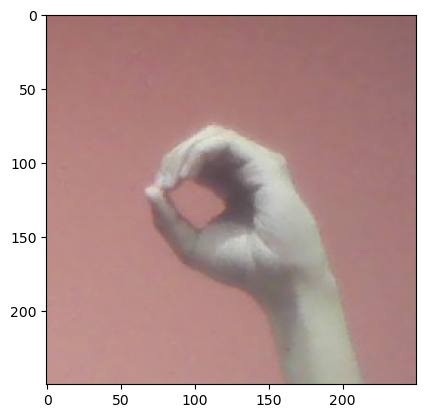

In [5]:
print("Sample ZERO image:")
img = load_img(files+'/1.jpg')
plt.imshow(img)
plt.show()

In [6]:
print(f'Each image of size {img_to_array(img).shape}')

Each image of size (250, 250, 3)


# Creating the data generator using ImageDataGenerator for the CNN

In [7]:
def train_val_generators():
    """
    Creates the training and validation data generators
    Args:
        TRAINING_DIR (string): directory path containing the training images
        VALIDATION_DIR (string): directory path containing the testing/validation images
    Returns:
        train_generator, validation_generator: tuple containing the generators
    """
    # Instantiate the ImageDataGenerator class, normalize pixel values and set arguments to augment the images 
    datagen = ImageDataGenerator(rescale=1.0/255.0, 
                                 rotation_range=10,
                                 width_shift_range=0.1,
                                 height_shift_range=0.1,
                                 shear_range=0.1,
                                 zoom_range=0.1,
                                 fill_mode='nearest',
                                 validation_split=0.1)                               
    # Pass in the appropriate arguments to the flow_from_directory method
    train_generator = datagen.flow_from_directory(directory=DIR,
                                                        batch_size=100, 
                                                        class_mode='categorical',
                                                        shuffle=True,
                                                        subset='training',                         
                                                        target_size=(224,224))

    # Pass in the appropriate arguments to the flow_from_directory method
    validation_generator = datagen.flow_from_directory(directory=DIR,
                                                                  batch_size=36, 
                                                                  class_mode='categorical',
                                                                  shuffle = False,
                                                                  subset='validation', 
                                                                  target_size=(224, 224))
    return train_generator, validation_generator

In [8]:
train_generator, validation_generator = train_val_generators()

Found 32400 images belonging to 36 classes.
Found 3600 images belonging to 36 classes.


# Define and compile the transfer learning model

In [21]:
pre_trained_model = tf.keras.applications.vgg19.VGG19(input_shape = (224, 224, 3), 
                                include_top = False, 
                                weights = 'imagenet')
for layer in pre_trained_model.layers:
    layer.trainable = False

80134624/80134624 [==============================] - 0s 0us/step


In [22]:
pre_trained_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [23]:
last_layer = pre_trained_model.get_layer('block5_pool')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 512)


In [24]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (36, activation='softmax')(x)           

# Append the dense network to the base model
model_transfer = Model(pre_trained_model.input, x) 

# Print the model summary. See your dense network connected at the end.
model_transfer.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [25]:
model_transfer.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Creating a Callback class

In [26]:
class myCallback(tf.keras.callbacks.Callback):
    # Define the correct function signature for on_epoch_end
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('val_accuracy') is not None and logs.get('val_accuracy') > 0.99): 
            print(logs.get('val_accuracy'))
            print("\nReached 99% validation accuracy so cancelling training!")
callbacks = myCallback()

In [27]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.25,   
    patience=2, 
    min_lr=0.00001,
    verbose=2
)

In [28]:
checkpoint_path = "/kaggle/working/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# Train the model

In [ ]:
history1 = model_transfer.fit(train_generator,
                    epochs=5,
                    validation_data=validation_generator, 
                    callbacks=[callbacks, reduce_lr, cp_callback]
                   )

Epoch 1/5
324/324 [==============================] - ETA: 0s - loss: 0.9556 - accuracy: 0.8001
Epoch 1: saving model to /kaggle/working/cp.ckpt
324/324 [==============================] - 528s 2s/step - loss: 0.9556 - accuracy: 0.8001 - val_loss: 1.1327 - val_accuracy: 0.6833 - lr: 0.0010
Epoch 2/5
324/324 [==============================] - ETA: 0s - loss: 0.1257 - accuracy: 0.9694
Epoch 2: saving model to /kaggle/working/cp.ckpt
324/324 [==============================] - 496s 2s/step - loss: 0.1257 - accuracy: 0.9694 - val_loss: 1.1347 - val_accuracy: 0.6872 - lr: 0.0010
Epoch 3/5
324/324 [==============================] - ETA: 0s - loss: 0.0736 - accuracy: 0.9811
Epoch 3: saving model to /kaggle/working/cp.ckpt
324/324 [==============================] - 473s 1s/step - loss: 0.0736 - accuracy: 0.9811 - val_loss: 1.1248 - val_accuracy: 0.6869 - lr: 0.0010
Epoch 4/5
324/324 [==============================] - ETA: 0s - loss: 0.0488 - accuracy: 0.9873
Epoch 4: saving model to /kaggle/worki

In [35]:
print("Accuracy of the transfer_learning model is - " , model_transfer.evaluate(validation_generator)[1]*100 , "%")

100/100 [==============================] - 50s 502ms/step - loss: 1.1862 - accuracy: 0.6733
Accuracy of the transfer_learning model is -  67.33333468437195 %


#  Evaluating Accuracy and Loss for the Model

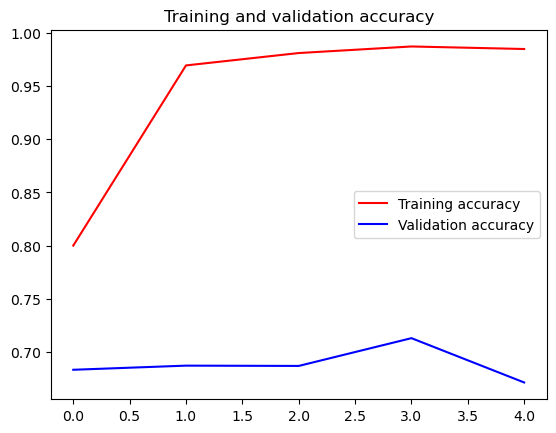

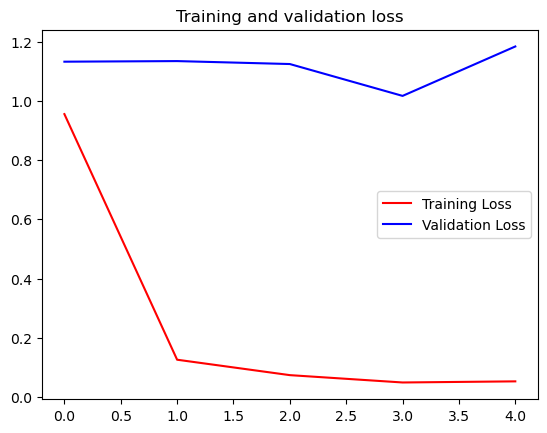

In [39]:
# Plot the chart for accuracy and loss on both training and validation
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [40]:
predictions = model_transfer.predict(validation_generator)
predictions=np.argmax(predictions,axis=-1)
print(predictions[:10])
print(validation_generator.labels[:10])

100/100 [==============================] - 46s 464ms/step
[ 0  0  0  0 28 28 30 28 28 28]
[0 0 0 0 0 0 0 0 0 0]


In [42]:
classes = []
for i in range(36):
    if i < 10:
        cls = str(i)
    else:
        cls = chr(i+55)
    classes.append(cls)

#  Evaluating  Precision, Recall, F1-Score and Support for the Model

In [43]:
print(classification_report(validation_generator.labels, predictions, target_names = classes))

              precision    recall  f1-score   support

           0       0.59      0.48      0.53       100
           1       0.84      0.88      0.86       100
           2       0.67      0.54      0.60       100
           3       0.63      0.97      0.77       100
           4       0.83      0.71      0.76       100
           5       0.90      0.56      0.69       100
           6       0.81      0.88      0.85       100
           7       0.92      0.71      0.80       100
           8       0.76      0.54      0.63       100
           9       0.64      0.54      0.59       100
           A       1.00      0.85      0.92       100
           B       1.00      0.51      0.68       100
           C       1.00      0.51      0.68       100
           D       0.89      0.56      0.69       100
           E       0.66      0.59      0.62       100
           F       0.98      0.47      0.64       100
           G       0.98      0.50      0.66       100
           H       0.48    

# Plotting the Confusion Matrix for the Classification

<AxesSubplot:>

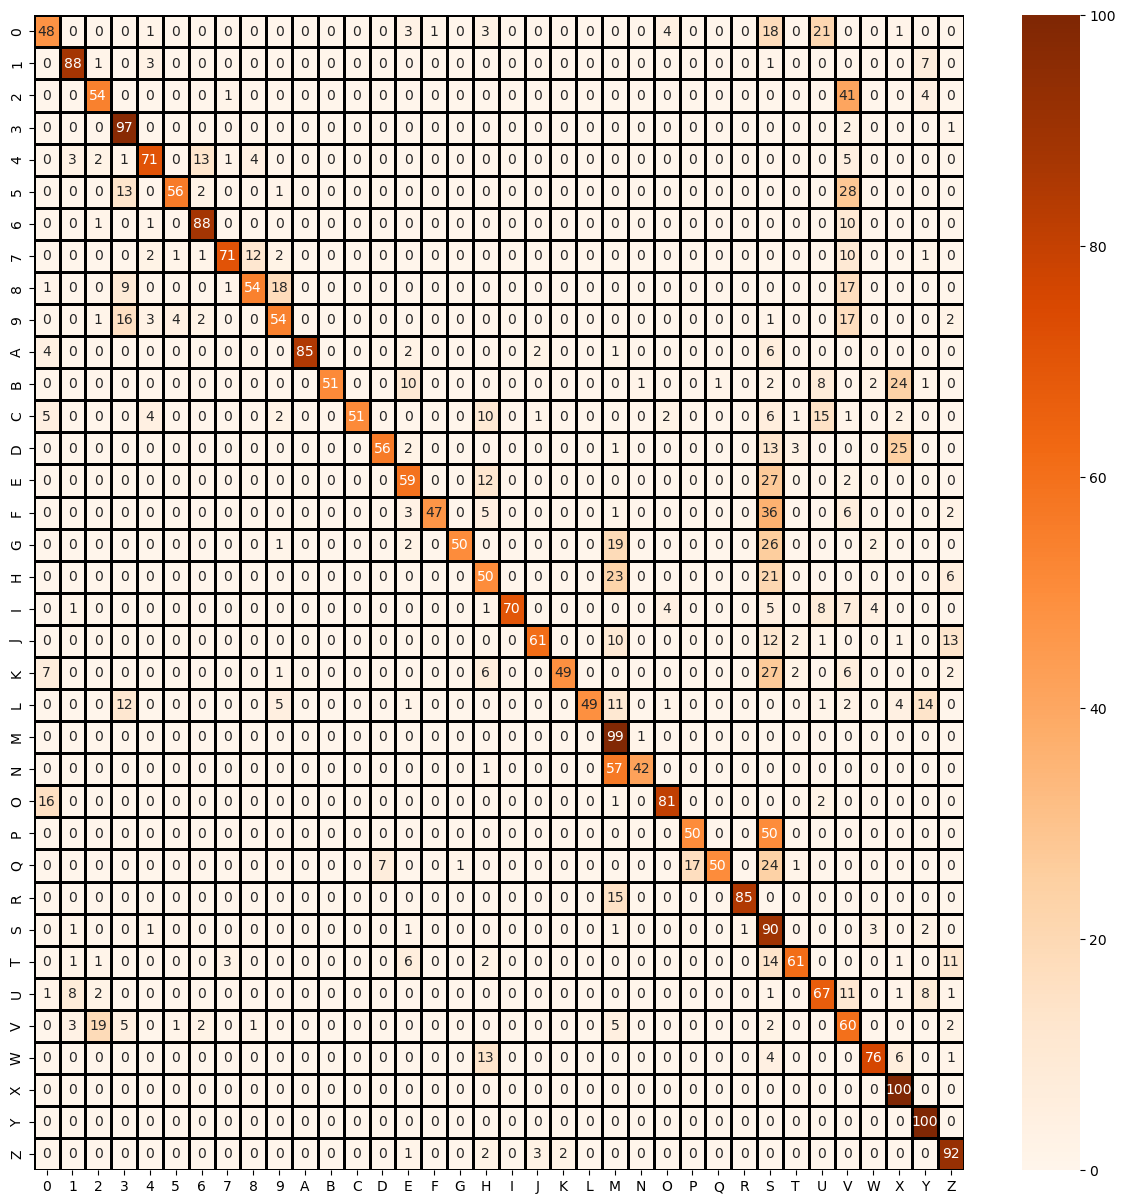

In [44]:
cm = confusion_matrix(validation_generator.labels,predictions)
cm = pd.DataFrame(cm , index = classes , columns = classes)
plt.figure(figsize = (15,15))
sns.heatmap(cm,cmap= "Oranges", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

# Sample Model Prediction

In [45]:
def clsindex_alphaa (cls_id):
    if cls_id <10:
        return str(cls_id)
    else:
        return chr(cls_id + 55)

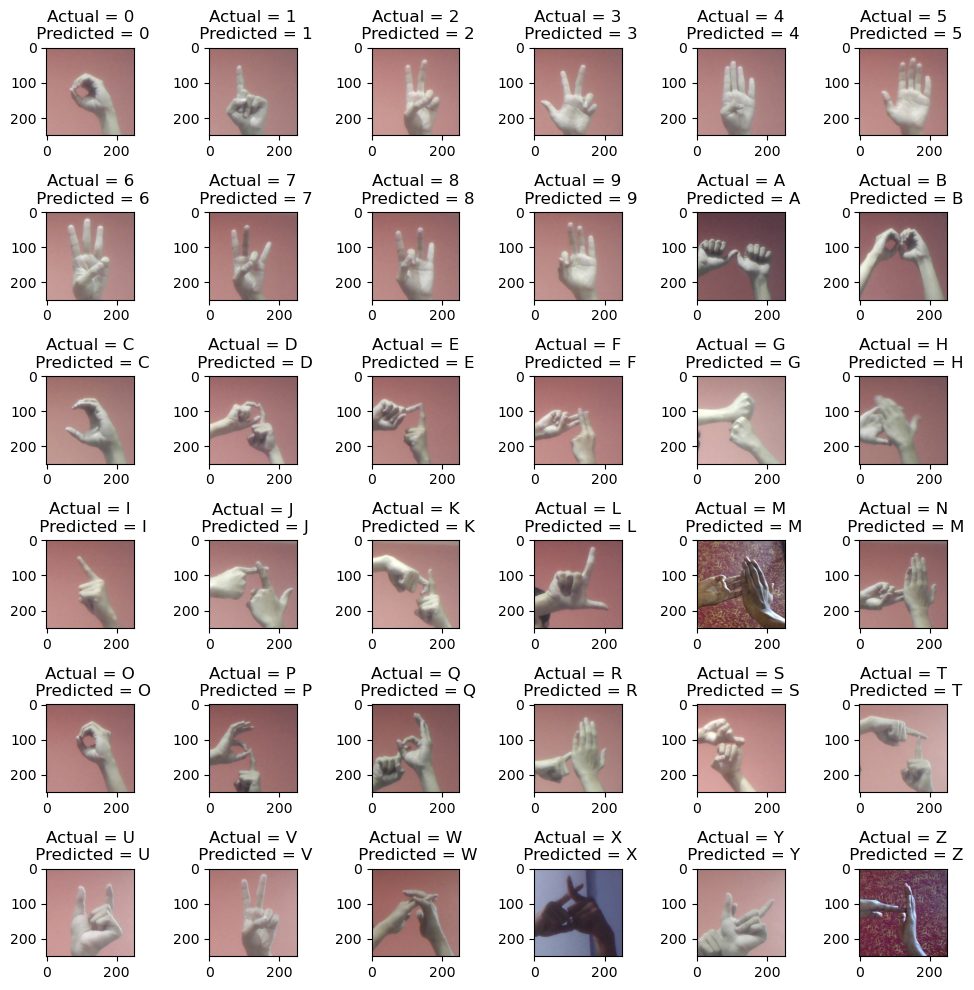

In [46]:
f, ax = plt.subplots(6,6) 
f.set_size_inches(10, 10)
k = 0
for i in range(6):
    for j in range(6):
        true_cls = clsindex_alphaa(validation_generator.labels[k])
        pred_cls = clsindex_alphaa(predictions[k])
        ax[i,j].set_title(f'Actual = {true_cls}\n Predicted = {pred_cls}')
        path = DIR + '/' + validation_generator.filenames[k]
        img=plt.imread(path)
        ax[i,j].imshow(img)
        k += 100
    plt.tight_layout() 